@misc{chollet2015keras,
  title={Keras},
  author={Chollet, Fran\c{c}ois and others},
  year={2015},
  howpublished={\url{https://keras.io}},
}

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

Define the path

In [2]:
path2data = os.path.join(os.getcwd(), "dataset", "train_data")
print(path2data)

h:\Approach2_sol\dataset\train_data


Split the data (80% train, 20% Validation) and resize the iamges

In [3]:
image_size = (64, 64)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    path2data,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 1351 files belonging to 6 classes.
Using 1081 files for training.
Using 270 files for validation.


Visualize the data

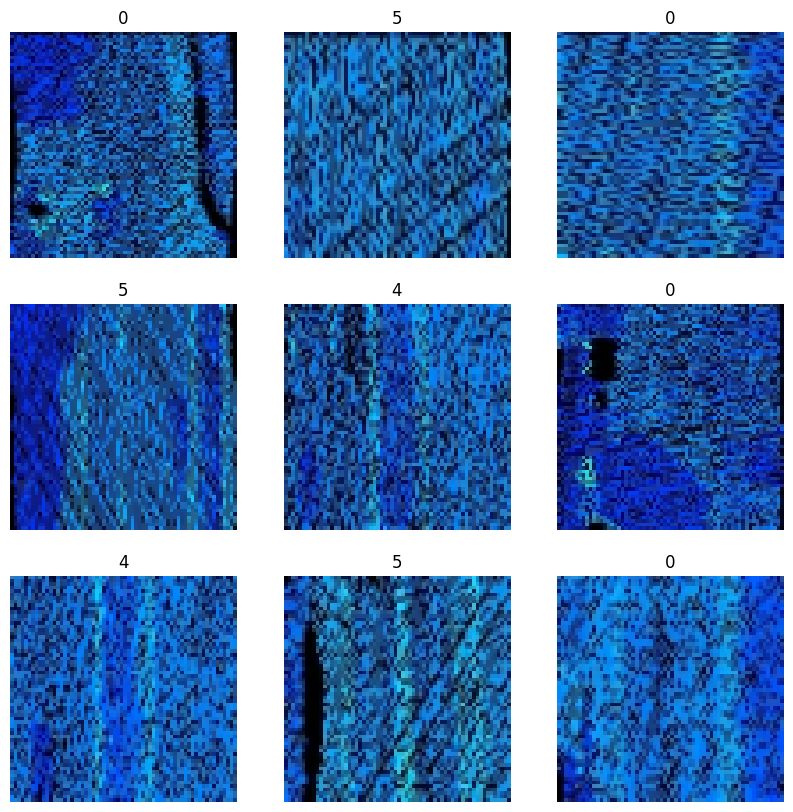

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
    ]
)

Visualize the augmented data

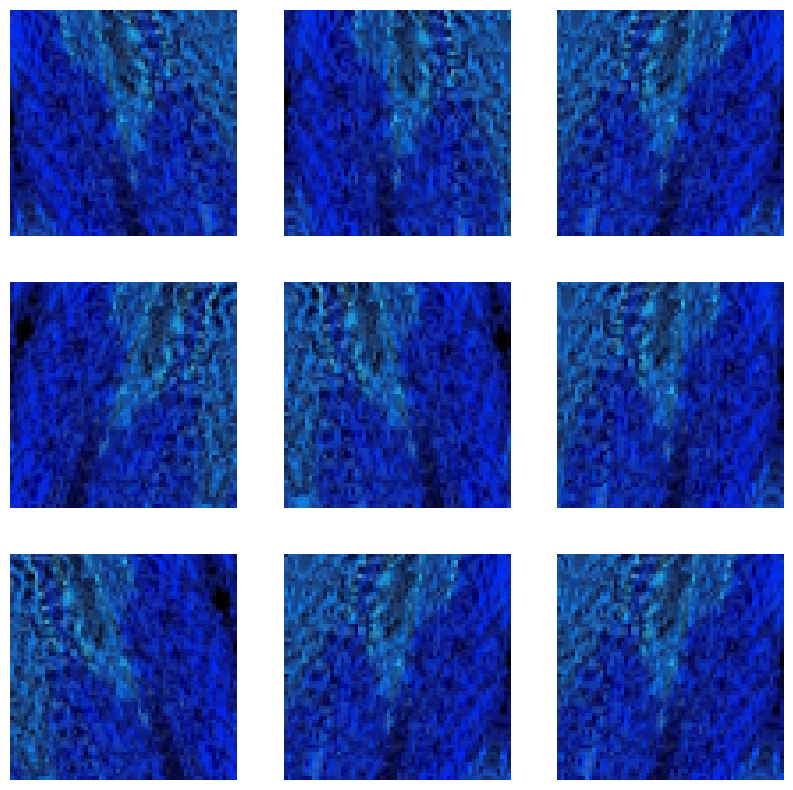

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

The model

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation="softmax")(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=6)
#keras.utils.plot_model(model, show_shapes=True)

Running the code

In [10]:
epochs = 20
num_classes=6

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

def preprocess_data(image, label):
    image = data_augmentation(image)  # Apply data augmentation
    label = tf.one_hot(label, depth=num_classes)  # Convert label to one-hot encoded using TensorFlow operation
    return image, label

train_ds = train_ds.map(lambda x, y: preprocess_data(x, y))
val_ds = val_ds.map(lambda x, y: preprocess_data(x, y))


model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/20
34/34 [==============================] - 32s 855ms/step - loss: 1.6041 - accuracy: 0.4024 - val_loss: 1.8129 - val_accuracy: 0.1593
Epoch 2/20
34/34 [==============================] - 29s 839ms/step - loss: 1.4177 - accuracy: 0.4829 - val_loss: 1.9459 - val_accuracy: 0.1593
Epoch 3/20
34/34 [==============================] - 29s 843ms/step - loss: 1.2633 - accuracy: 0.5513 - val_loss: 2.1972 - val_accuracy: 0.1593
Epoch 4/20
34/34 [==============================] - 30s 873ms/step - loss: 1.1991 - accuracy: 0.5615 - val_loss: 2.5573 - val_accuracy: 0.1704
Epoch 5/20
34/34 [==============================] - 29s 846ms/step - loss: 1.1645 - accuracy: 0.5652 - val_loss: 2.8359 - val_accuracy: 0.1000
Epoch 6/20
34/34 [==============================] - 29s 850ms/step - loss: 1.0920 - accuracy: 0.5967 - val_loss: 3.2935 - val_accuracy: 0.1000
Epoch 7/20
34/34 [==============================] - 29s 847ms/step - loss: 1.0047 - accuracy: 0.6068 - val_loss: 3.6536 - val_accuracy: 0.1000

Testing the model using the test_data

In [17]:
class_labels = ['2lanes', '3lanes', 'crossing', 'split4lanes', 'split6lanes', 'transition']
image_size = (64, 64)

# Load and preprocess the image
img = keras.utils.load_img("H:\\Approach2_sol\\dataset\\test_data\\2lanes\\Tile239.jpg", target_size=image_size)
resized_img = img.resize(image_size[:2])  # Resize the image to match the expected input size
img_array = keras.utils.img_to_array(resized_img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)
predicted_class_index = tf.argmax(predictions, axis=-1)
predicted_class_label = class_labels[predicted_class_index[0]]
confidence = predictions[0][predicted_class_index][0]

print(f"This image is {confidence * 100:.2f}% {predicted_class_label}.")

1/1 [==============================] - 0s 67ms/step
This image is 83.05% 2lanes.
